In [1]:
!pip install keras==2.14.0
!pip install tensorflow
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.6 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.14.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0


In [2]:
# Import the python library we need
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from keras.layers import Dropout

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

In [3]:
# Get stock data, assuming you already have a data set with 30 stock prices
# Random data is used here, it needs to be replaced by a real dataframe
# dataframe = pd.read_csv('Stockprice.csv')
np.random.seed(42)
data = np.random.rand(100, 30)
columns = [f'stock{i}' for i in range(1, 31)]
dataframe = pd.DataFrame(data, columns=columns)
dataframe.head()

,stock1,stock2,stock3,stock4,stock5,stock6,stock7,stock8,stock9,stock10,...,stock21,stock22,stock23,stock24,stock25,stock26,stock27,stock28,stock29,stock30
0,0.374540,0.950714,0.731994,0.598658,0.156019,0.155995,0.058084,0.866176,0.601115,0.708073,...,0.611853,0.139494,0.292145,0.366362,0.456070,0.785176,0.199674,0.514234,0.592415,0.046450
1,0.607545,0.170524,0.065052,0.948886,0.965632,0.808397,0.304614,0.097672,0.684233,0.440152,...,0.969585,0.775133,0.939499,0.894827,0.597900,0.921874,0.088493,0.195983,0.045227,0.325330
2,0.388677,0.271349,0.828738,0.356753,0.280935,0.542696,0.140924,0.802197,0.074551,0.986887,...,0.863103,0.623298,0.330898,0.063558,0.310982,0.325183,0.729606,0.637557,0.887213,0.472215
3,0.119594,0.713245,0.760785,0.561277,0.770967,0.493796,0.522733,0.427541,0.025419,0.107891,...,0.289751,0.161221,0.929698,0.808120,0.633404,0.871461,0.803672,0.186570,0.892559,0.539342
4,0.807440,0.896091,0.318003,0.110052,0.227935,0.427108,0.818015,0.860731,0.006952,0.510747,...,0.962447,0.251782,0.497249,0.300878,0.284840,0.036887,0.609564,0.502679,0.051479,0.278646


In [4]:
dataframe.shape

(100, 30)

In [5]:
# Divide the training set and the test set (here I use the first 80% of the time interval data as the training set and the last 20% as the test set)
# Using 80% time period as training set, 20% as testing set
train_ratio = 0.8
training_set_size = int(dataframe.shape[0] * train_ratio)
train_data = dataframe[ :training_set_size]
test_data = dataframe[training_set_size :]


# Normalized processing
scaler = MinMaxScaler(feature_range=(0, 1))
normalize_train_data = scaler.fit_transform(train_data)
normalize_test_data = scaler.fit_transform(test_data)





In [6]:
print(normalize_test_data.shape)
print(normalize_train_data.shape)
type(normalize_train_data)

(20, 30)
(80, 30)


numpy.ndarray

In [23]:
def create_dataset(data,n_predictions,nth):
    train_X,train_y = [],[]
    for i in range(data.shape[0]-n_predictions-nth-1):
        a = data[i:(i+n_predictions),:]
        train_X.append(a)
        b = data[i+n_predictions+nth,:]
        train_y.append(b)
    train_X = np.array(train_X,dtype='float64')
    train_y = np.array(train_y,dtype='float64')

    return train_X, train_y

In [24]:
# generate train_X,train_y,test_X,test_y
# using previous 10 steps to predict next 3th steps, this 2 can be change when you do the real stock training
train_X,train_y = create_dataset(normalize_train_data,10,3)
test_X,test_y = create_dataset(normalize_test_data,10,3)

In [26]:
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(66, 10, 30)
(66, 30)
(6, 10, 30)
(6, 30)


In [27]:
# Contruct our model
def LSTM_model(lstm_neurons=50,dropout=0.2,activation='relu',dense_units='20',optimizer='adam'):
  X = train_X
  y = train_y
  LSTM_model = Sequential()
  # Hidden layer 1: LSTM
  LSTM_model.add(LSTM(lstm_neurons, input_shape=(X.shape[1], X.shape[2]), activation=activation,return_sequences=True))
  LSTM_model.add(Dropout(dropout))
  # Hidden layer 2: LSTM
  LSTM_model.add(LSTM(lstm_neurons, activation=activation,return_sequences=False))
  # If needed, you can add more lstm layers here

  # Output layer: Dense
  LSTM_model.add(Dense(y.shape[1]))
  # Configure the model
  LSTM_model.compile(optimizer ,loss='mean_squared_error')
  return LSTM_model


In [28]:
# Define our alternative hyperparameters directionary
# The parameters in this table can be expanded
parameters_grid = { 'model__lstm_neurons': [50,60,70],
           'model__activation': ['relu', 'tanh', 'sigmoid'],
           'model__optimizer':['adam', 'rmsprop','sgd'],

}

In [29]:
 # Grid search
model = KerasRegressor(model=LSTM_model, epochs=100, batch_size=32, verbose=2)
grid = GridSearchCV(estimator=model, param_grid = parameters_grid, scoring='neg_mean_squared_error',cv=3, error_score='raise')

grid_result = grid.fit(train_X, train_y)
# Display the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# Print the result
print("Best Parameters for our LSTM model is : ", grid_result.best_params_)

Epoch 1/100
2/2 - 2s - loss: 0.3331 - 2s/epoch - 1s/step
Epoch 2/100
2/2 - 0s - loss: 0.3081 - 15ms/epoch - 8ms/step
Epoch 3/100
2/2 - 0s - loss: 0.2824 - 14ms/epoch - 7ms/step
Epoch 4/100
2/2 - 0s - loss: 0.2550 - 16ms/epoch - 8ms/step
Epoch 5/100
2/2 - 0s - loss: 0.2300 - 16ms/epoch - 8ms/step
Epoch 6/100
2/2 - 0s - loss: 0.2102 - 24ms/epoch - 12ms/step
Epoch 7/100
2/2 - 0s - loss: 0.1899 - 20ms/epoch - 10ms/step
Epoch 8/100
2/2 - 0s - loss: 0.1696 - 17ms/epoch - 8ms/step
Epoch 9/100
2/2 - 0s - loss: 0.1478 - 18ms/epoch - 9ms/step
Epoch 10/100
2/2 - 0s - loss: 0.1344 - 18ms/epoch - 9ms/step
Epoch 11/100
2/2 - 0s - loss: 0.1229 - 15ms/epoch - 8ms/step
Epoch 12/100
2/2 - 0s - loss: 0.1193 - 17ms/epoch - 9ms/step
Epoch 13/100
2/2 - 0s - loss: 0.1108 - 15ms/epoch - 8ms/step
Epoch 14/100
2/2 - 0s - loss: 0.1053 - 14ms/epoch - 7ms/step
Epoch 15/100
2/2 - 0s - loss: 0.1022 - 15ms/epoch - 7ms/step
Epoch 16/100
2/2 - 0s - loss: 0.0985 - 14ms/epoch - 7ms/step
Epoch 17/100
2/2 - 0s - loss: 0.09

1/1 - 0s - 199ms/epoch - 199ms/step
Epoch 1/100
2/2 - 2s - loss: 0.3374 - 2s/epoch - 1s/step
Epoch 2/100
2/2 - 0s - loss: 0.2783 - 16ms/epoch - 8ms/step
Epoch 3/100
2/2 - 0s - loss: 0.2265 - 14ms/epoch - 7ms/step
Epoch 4/100
2/2 - 0s - loss: 0.1903 - 16ms/epoch - 8ms/step
Epoch 5/100
2/2 - 0s - loss: 0.1687 - 16ms/epoch - 8ms/step
Epoch 6/100
2/2 - 0s - loss: 0.1577 - 18ms/epoch - 9ms/step
Epoch 7/100
2/2 - 0s - loss: 0.1407 - 15ms/epoch - 7ms/step
Epoch 8/100
2/2 - 0s - loss: 0.1344 - 23ms/epoch - 12ms/step
Epoch 9/100
2/2 - 0s - loss: 0.1257 - 16ms/epoch - 8ms/step
Epoch 10/100
2/2 - 0s - loss: 0.1173 - 22ms/epoch - 11ms/step
Epoch 11/100
2/2 - 0s - loss: 0.1161 - 17ms/epoch - 8ms/step
Epoch 12/100
2/2 - 0s - loss: 0.1073 - 20ms/epoch - 10ms/step
Epoch 13/100
2/2 - 0s - loss: 0.1031 - 18ms/epoch - 9ms/step
Epoch 14/100
2/2 - 0s - loss: 0.1031 - 16ms/epoch - 8ms/step
Epoch 15/100
2/2 - 0s - loss: 0.1052 - 15ms/epoch - 8ms/step
Epoch 16/100
2/2 - 0s - loss: 0.1015 - 26ms/epoch - 13ms/s

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch 14/100
2/2 - 0s - loss: 0.0925 - 26ms/epoch - 13ms/step
Epoch 15/100
2/2 - 0s - loss: 0.0917 - 24ms/epoch - 12ms/step
Epoch 16/100
2/2 - 0s - loss: 0.0903 - 20ms/epoch - 10ms/step
Epoch 17/100
2/2 - 0s - loss: 0.0895 - 22ms/epoch - 11ms/step
Epoch 18/100
2/2 - 0s - loss: 0.0908 - 27ms/epoch - 14ms/step
Epoch 19/100
2/2 - 0s - loss: 0.0884 - 23ms/epoch - 12ms/step
Epoch 20/100
2/2 - 0s - loss: 0.0892 - 20ms/epoch - 10ms/step
Epoch 21/100
2/2 - 0s - loss: 0.0883 - 24ms/epoch - 12ms/step
Epoch 22/100
2/2 - 0s - loss: 0.0888 - 24ms/epoch - 12ms/step
Epoch 23/100
2/2 - 0s - loss: 0.0881 - 26ms/epoch - 13ms/step
Epoch 24/100
2/2 - 0s - loss: 0.0887 - 23ms/epoch - 11ms/step
Epoch 25/100
2/2 - 0s - loss: 0.0886 - 25ms/epoch - 13ms/step
Epoch 26/100
2/2 - 0s - loss: 0.0889 - 27ms/epoch - 13ms/step
Epoch 27/100
2/2 - 0s - loss: 0.0883 - 28ms/epoch - 14ms/step
Epoch 28/100
2/2 - 0s - loss: 0.0878 - 29ms/epoch - 14ms/step
Epoch 29/100
2/2 - 0s - loss: 0.0883 - 29ms

In [30]:
# Train our LSTM model
def train_model(X,y,lstm_neurons,dropout,activation,dense_units,optimizer='adam'):
  LSTM_model = Sequential()
  # Hidden layer 1: LSTM
  LSTM_model.add(LSTM(lstm_neurons, input_shape=(X.shape[1], X.shape[2]), activation=activation,return_sequences=True))
  LSTM_model.add(Dropout(dropout))
  # Hidden layer 2: LSTM
  LSTM_model.add(LSTM(lstm_neurons, activation=activation,return_sequences=False))
  # If needed, you can add more lstm layers here

  # Output layer: Dense
  LSTM_model.add(Dense(y.shape[1]))
  # Configure the model
  LSTM_model.compile(optimizer ,loss='mean_squared_error')
  return LSTM_model
our_model = train_model(X=train_X,y=train_y,lstm_neurons=60,dropout=0.2,activation='sigmoid',dense_units='20',optimizer='adam')
history = our_model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(test_X, test_y),verbose=1)


Epoch 1/200
3/3 [==============================] - 2s 158ms/step - loss: 0.4696 - val_loss: 0.4017
Epoch 2/200
3/3 [==============================] - 0s 18ms/step - loss: 0.3440 - val_loss: 0.3050
Epoch 3/200
3/3 [==============================] - 0s 17ms/step - loss: 0.2551 - val_loss: 0.2363
Epoch 4/200
3/3 [==============================] - 0s 17ms/step - loss: 0.1952 - val_loss: 0.1884
Epoch 5/200
3/3 [==============================] - 0s 18ms/step - loss: 0.1542 - val_loss: 0.1563
Epoch 6/200
3/3 [==============================] - 0s 17ms/step - loss: 0.1297 - val_loss: 0.1349
Epoch 7/200
3/3 [==============================] - 0s 18ms/step - loss: 0.1136 - val_loss: 0.1205
Epoch 8/200
3/3 [==============================] - 0s 21ms/step - loss: 0.1035 - val_loss: 0.1103
Epoch 9/200
3/3 [==============================] - 0s 18ms/step - loss: 0.0981 - val_loss: 0.1033
Epoch 10/200
3/3 [==============================] - 0s 19ms/step - loss: 0.0952 - val_loss: 0.0986
Epoch 11/200
3/3 [

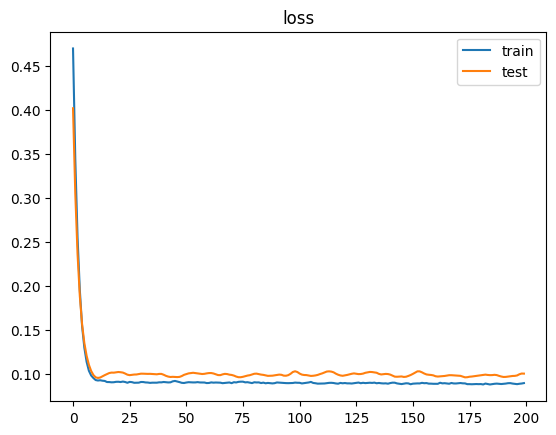

In [31]:
# plot history loss graph
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'],label='test')
plt.title('loss')
plt.legend()
plt.show()

In [35]:
y_hat  =  our_model.predict(test_X)
print(y_hat.shape)
original_y_hat = scaler.inverse_transform(y_hat)
original_y_test = scaler.inverse_transform(test_y)

1/1 [==============================] - 0s 15ms/step
(6, 30)


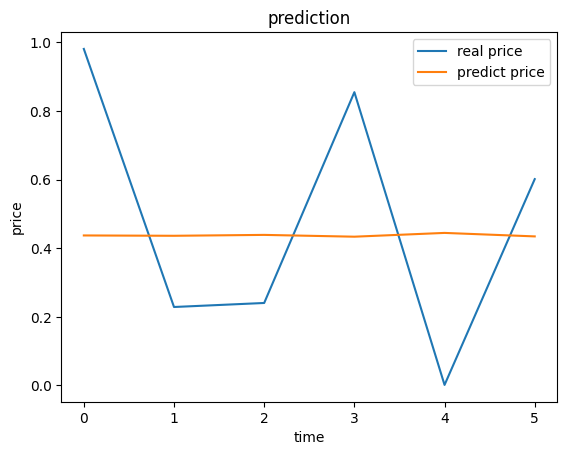

0.08622341294799375


In [36]:

# for example we want to see the ith stock in this 30 stocks
# we try to see the 1st stock
i=1
plt.plot(original_y_test[:,i],label='real price')
plt.plot(original_y_hat[:,i],label='predict price')
plt.legend()
plt.title('prediction')
plt.xlabel('time')
plt.ylabel('price')
plt.show()
# error measure
test_MSE = mean_squared_error(original_y_test, original_y_hat)
print(test_MSE)